# Solving Inverse Problems with Pretrained Convex-Ridge Regularizers

This notebook gives a few basic snippets to use CRR-NNs.

In [1]:
import torch
from torchmetrics.functional import peak_signal_noise_ratio as psnr

import sys
sys.path.append('../')
from models import utils

In [2]:
device = 'cuda:0'
torch.set_grad_enabled(False)
torch.set_num_threads(4)

## 1. Loading and Pruning a Model

Each CRR-NN was trained with a noise level $\sigma\in\{5/255, 25/255\}$ with a $t$-step denoising process, for $t\in\{1, 2, 5, 10, 20, 30, 50\}$.

(some other models were trained on MRI/CT images with $\sigma\in\{5/255, 25/255\}$ and $t=10$)

In [3]:
sigma_training = 5
t = 10

exp_name = f'Sigma_{sigma_training}_t_{t}'
model = utils.load_model(exp_name, device)

--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------


 Prunning CRR-NNs:
 - The training of CRR-NNs is carried out with a regularization on the activation functions. This typically yields some activation functions to be almost vanishing. The associated filters can hence be removed.
 - The training is carried out with composition of convolutions. After training, these can be turned into standard convolutions for improved efficiency. Nb: we observed a small loss of performance this for denoising (~0.05dB) but we did not see as of now a noticeable changen for solving inverse problems.

In [4]:
print(f'Numbers of parameters before prunning: {model.num_params}')
# prunning is optional, leads to faster inference but can reduce slightly the performances, use only if you have a good reason to do so
model.prune(change_splines_to_clip=False, prune_filters=True, collapse_filters=True)
print(f'Numbers of parameters after prunning: {model.num_params}')

Numbers of parameters before prunning: 13610
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373
Numbers of parameters after prunning: 4373


## 2. Using the Models

Lipschitz bound
(not used if optimizing with AdaGD)

In [5]:
# intialize the eigen vector of dimension (size, size) associated to the largest eigen value
model.initializeEigen(size=100)
# compute bound via a power iteration which couples the activations and the convolutions
model.precise_lipschitz_bound(n_iter=100)
# the bound is stored in the model
L = model.L.data.item()
print(f"Lipschitz bound {L:.3f}")

Lipschitz bound 1.022


Gradient

In [6]:
im = torch.empty((1, 1, 100, 100), device=device).uniform_()
grad = model.grad(im)# alias for model.forward(im) and hence model(im)

Regularization Cost

The regularization cost is not used during training. On the fisrt call, the construction of the potential functions is triggered. Th activation functions are expressed with linear B-splines and the profile functions with quadratic B-splines.

In [7]:
im = torch.empty((1, 1, 100, 100), device=device).uniform_()
cost = model.cost(100*im)

-----------------------
Updating spline coefficients for the reg cost
 (the gradient-step model is trained and intergration is required to compute the regularization cost)
-----------------------


## A Toy Example

We give a toy example of image denoising. For the BSD68 test, see the folder ../denoising/

In [8]:
import matplotlib.pyplot as plt
import cv2
import math
sys.path.append('../inverse_problems')
from utils_inverse_problems.reconstruction_map_crr import AdaGD_Recon, AGD_Recon

In [9]:
img = cv2.resize(cv2.imread("./image/sample.JPG", cv2.IMREAD_GRAYSCALE), (504, 378))
img_torch = torch.tensor(img, device=device).reshape((1,1) + img.shape)/255
img_torch_noisy = img_torch + 25/255 * torch.randn_like(img_torch)

To solve the problem

<img src="https://latex.codecogs.com/svg.image?\mathrm{argmin}_{\mathbf{x}}&space;\frac{1}{2}\|\mathbf{H}\mathbf{x}&space;-&space;\mathbf{y}\|_2^2&space;&plus;\lambda/\mu&space;R_{t,\sigma}(\mu\mathbf{x})." />

one can use any gradient-based method since the objective is smooth. Usually accelerated gradient descent (AGD) is a safe choice, in some cases the adaptive gradient descent AdaGD is better. Remark: with both algorithms, positivity can be enforced with convergence guarantees (then AGD becomes FISTA for e.g.).

The implementation of the algorithms is given in `inverse_problems/utils_inverse_problems/reconstruction_maop_crr`.

In [16]:
# define the forward operator and its adjoint
# here, for denoising Id
H = lambda x: x
Ht = lambda x: x

lmbd = 25
mu = 4

x_out, psnr_, ssim_, n_iter = AdaGD_Recon(y=img_torch_noisy, H=H, Ht=Ht, model=model, lmbd=lmbd, mu=mu, x_gt=img_torch, tol=1e-6, max_iter=200)

x_out, psnr_, ssim_, n_iter = AGD_Recon(y=img_torch_noisy, H=H, Ht=Ht, model=model, lmbd=25, mu=3, x_gt=img_torch, tol=1e-5, strong_convexity_constant=1, max_iter=200)

psnr: 23.91 | ssim: 0.7823 | res: 6.85e-06: 100%|██████████| 200/200 [00:02<00:00, 70.48it/s]
psnr: 23.91 | ssim: 0.7810 | res: 1.06e-05:  49%|████▉     | 98/200 [00:01<00:01, 64.37it/s]


If tracking the cost is needed.

Nb: the current implementation is not optimal. We compute the cost and the gradient independently, but both require to compute first the filtered version of the input ($\mathbf{W}\mathbf{x}$), which could be done only once.

psnr: 23.91 | ssim: 0.7810 | res: 9.19e-07:  95%|█████████▌| 190/200 [00:05<00:00, 37.60it/s]
psnr: 23.91 | ssim: 0.7810 | res: 1.06e-05:  49%|████▉     | 98/200 [00:02<00:02, 36.63it/s]


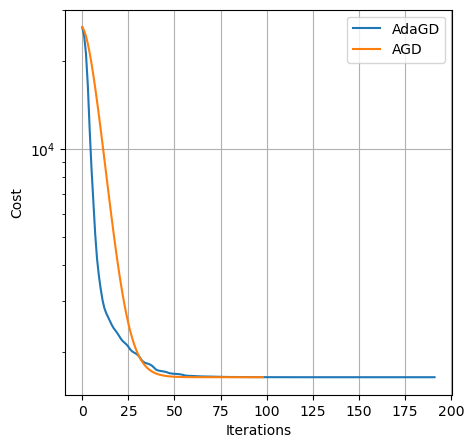

In [14]:
x_out1, psnr_list1, ssim_list1, i1, cost1, n_restart1, grad_norm_list1 = AdaGD_Recon(y=img_torch_noisy, H=H, Ht=Ht, model=model, lmbd=lmbd, mu=mu, x_gt=img_torch, tol=1e-6, max_iter=200, track_cost=True)

x_out2, psnr_list2, ssim_list2, i2, cost2, n_restart2, grad_norm_list2 = AGD_Recon(y=img_torch_noisy, H=H, Ht=Ht, model=model, lmbd=25, mu=3, x_gt=img_torch, tol=1e-5, strong_convexity_constant=1, max_iter=200, track_cost=True)

plt.figure(figsize=(5, 5))
plt.plot(cost1, label='AdaGD')
plt.plot(cost2, label='AGD')
plt.grid()
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.yscale('log')
plt.show()

Visualization

[]

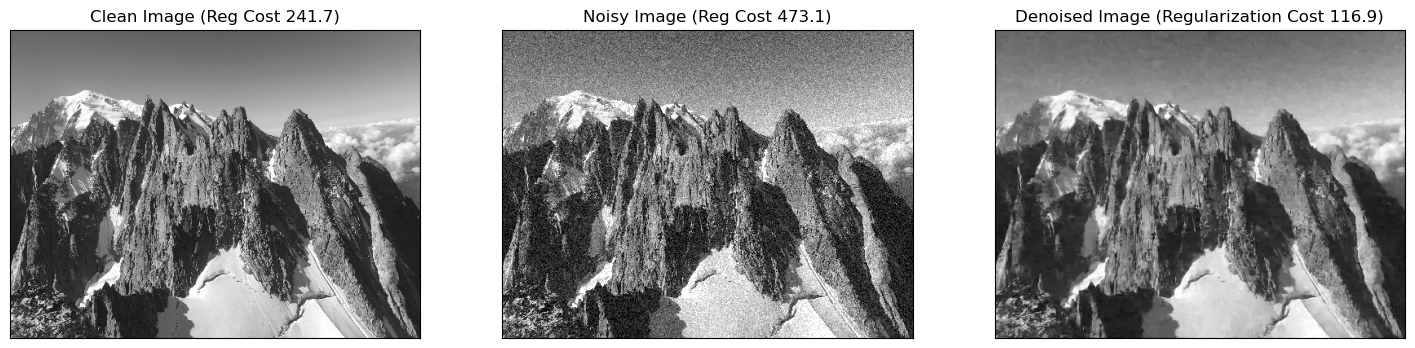

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
ax[0].set_title(f"Clean Image (Reg Cost {model.cost(mu*img_torch)[0].item():.1f})")
ax[0].imshow(img_torch.detach().cpu().squeeze(), cmap="gray", vmin=0, vmax=1)
ax[0].set_yticks([])
ax[0].set_xticks([])

ax[1].set_title(f"Noisy Image (Reg Cost {model.cost(mu*img_torch_noisy)[0].item():.1f})")
ax[1].imshow(img_torch_noisy.detach().cpu().squeeze(), cmap="gray", vmin=0, vmax=1)
ax[1].set_yticks([])
ax[1].set_xticks([])

ax[2].set_title(f"Denoised Image (Regularization Cost {model.cost(mu*x_out)[0].item():.1f})")
ax[2].imshow(x_out.detach().cpu().squeeze(), cmap="gray", vmin=0, vmax=1)
ax[2].set_yticks([])
ax[2].set_xticks([])